In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
from numpy.random import choice
from scipy.optimize import curve_fit

In [5]:
import matplotlib.pyplot as plt
from plotting import initialize_plot_settings
initialize_plot_settings()

In [6]:
from disloc import deform_dislocation
from utils import apply_water_mask, load_and_mask_results, rotate

In [7]:
ORIGIN_X = 321660
ORIGIN_Y = 4164942

In [8]:
filename = f'results/sfm/strike_slip/HSLSurvey101419_utm_s310.00_d90.00_dep100.00_ss1.00_ds0.00_ICP_w50.00_str25.00.pkl'
x, y, ux, uy, uz, residual, mask = load_and_mask_results(filename, iterations=2)
xx, yy = np.meshgrid(x, y)

## Convenience functions

In [9]:
def rmse(ypred, yobs):
    return np.sqrt(np.nanmean((ypred - yobs) ** 2))

In [10]:
def model_2d(depth, slip_ds, slip_ss, strike=310, dip=89.999, x=x, y=y, origin_x=ORIGIN_X, origin_y=ORIGIN_Y):
    if x.ndim < 2:
        x, y = np.meshgrid(x, y)
    x0 = np.mean(x) if origin_x is None else origin_x
    y0 = np.mean(y) if origin_y is None else origin_y

    xt = x - x0
    yt = y - y0

    deltarad = np.deg2rad(dip)
    thetarad = np.deg2rad(strike)
    X1p = xt * np.cos(np.pi - thetarad) + yt * np.sin(np.pi - thetarad)
    Zeta = (X1p / depth) - (1 / np.tan(deltarad))
    u1 = (slip_ds / np.pi) * (
        np.cos(deltarad) * np.arctan(Zeta)
        + (np.sin(deltarad) - Zeta * np.cos(deltarad)) / (1 + np.power(Zeta, 2))
    )
    u3 = (-slip_ds / np.pi) * (
        np.sin(deltarad) * np.arctan(Zeta)
        + (np.cos(deltarad) + Zeta * np.sin(deltarad)) / (1 + np.power(Zeta, 2))
    )
    u2 = (slip_ss / np.pi) * (
        np.arctan2(
            Zeta * np.power(np.sin(deltarad), 2),
            (1 - Zeta * np.sin(deltarad) * np.cos(deltarad)),
        )
        + (deltarad - np.sign(deltarad) * np.pi / 2.0)
    )

    u1p = u1 * np.cos(thetarad - np.pi) + u2 * np.sin(thetarad - np.pi)
    u2p = -u1 * np.sin(thetarad - np.pi) + u2 * np.cos(thetarad - np.pi)
    
    up, un = rotate(u1p, u2p, theta=50)
    
    return up, u3

## RMSE - Baseline (no deformation) displacements

In [69]:
def plot_rmse_2param_lidar(dx=50, num=100, max_depth=500, max_slip=5, ax=None, color='k', normalize=False):
    filename = f'results/lidar/HSLLidar_2017baseline_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uobs, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs = apply_water_mask(uobs, dx=dx)
    
    depths = np.linspace(0, max_depth, num=num) + 0.01
    slips = np.linspace(-max_slip, max_slip, num=2*num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                _, upred = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    if ax is None:
        return depths, slips, rmses
    
    idx = np.where(rmses == np.nanmin(rmses))
    i = idx[0][-num]
    j = idx[1][-num]
    k = idx[2][-num]
    
    if dx == 50:
        im = ax[0].imshow(rmses[:, :, k], extent=extent, aspect='auto', cmap='gray')
        c = ax[0].contour(rmses[:, :, k], levels=[0.6, 1, 1.5], extent=extent, aspect='auto', colors='w', origin='upper')
        ax[0].plot(slips[j], depths[i], 'w*', ms=10)
        ax[0].clabel(c, fmt='%.1f m', fontsize=12)
        #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])

        ax[0].invert_yaxis()
        ax[0].set_xlim([0, max_slip])
    
    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')
    
    if normalize:
        rmses /= 0.07
        #rmses /= np.nanmin(rmses)
    
    ax[1].plot(depths, rmses[:, j, k], '-', c=color, label=f'{dx:.0f} m')
    
    ax[2].plot(slips, rmses[i, :, k], '-', c=color, label=f'{dx:.0f} m')    
    ax[2].plot(slips, rmses[i, j, :], '--', c=color)

    return depths, slips, rmses


In [72]:
def plot_rmse_2param_sameday1(dx=50, num=100, max_depth=500, max_slip=5, ax=None, color='k', normalize=False):
    filename = f'results/sfm/HSLSurvey101319_utm_thin5baseline_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uobs, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs = apply_water_mask(uobs, dx=dx)
    
    depths = np.linspace(0, max_depth, num=num) + 0.01
    slips = np.linspace(-max_slip, max_slip, num=2*num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                _, upred = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    idx = np.where(rmses == np.nanmin(rmses))
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    if dx == 50:
        im = ax[0].imshow(rmses[:, :, k], extent=extent, aspect='auto', cmap='gray')
        c = ax[0].contour(rmses[:, :, k], levels=[0.6, 1, 1.5], extent=extent, aspect='auto', colors='w', origin='upper')
        ax[0].plot(slips[j], depths[i], 'w*', ms=10)
        ax[0].clabel(c, fmt='%.1f m', fontsize=12)
        #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])

        ax[0].invert_yaxis()
        ax[0].set_xlim([0, max_slip])
    
    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')
    
    if normalize:
        rmses /= 0.07
        #rmses /= np.nanmin(rmses)
    
    ax[1].plot(depths, rmses[:, j, k], '-', c=color, label=f'{dx:.0f} m')
    
    ax[2].plot(slips, rmses[i, :, k], '-', c=color, label=f'{dx:.0f} m')    
    ax[2].plot(slips, rmses[i, j, :], '--', c=color)

    return depths, slips, rmses


In [ ]:
def plot_rmse_2param_sameday2(dx=50, num=100, max_depth=500, max_slip=5, ax=None, color='k', normalize=False):
    filename = f'results/sfm/HSLSurvey101419_utm_thin5baseline2_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uobs, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs = apply_water_mask(uobs, dx=dx)
    
    depths = np.linspace(0, max_depth, num=num) + 0.01
    slips = np.linspace(-max_slip, max_slip, num=2*num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                _, upred = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    idx = np.where(rmses == np.nanmin(rmses))
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    if dx == 50:
        im = ax[0].imshow(rmses[:, :, k], extent=extent, aspect='auto', cmap='gray')
        c = ax[0].contour(rmses[:, :, k], levels=[0.6, 1, 1.5], extent=extent, aspect='auto', colors='w', origin='upper')
        ax[0].plot(slips[j], depths[i], 'w*', ms=10)
        ax[0].clabel(c, fmt='%.1f m', fontsize=12)
        #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])

        ax[0].invert_yaxis()
        ax[0].set_xlim([0, max_slip])
    
    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')
    
    if normalize:
        rmses /= 0.07
        #rmses /= np.nanmin(rmses)
    
    ax[1].plot(depths, rmses[:, j, k], '-', c=color, label=f'{dx:.0f} m')
    
    ax[2].plot(slips, rmses[i, :, k], '-', c=color, label=f'{dx:.0f} m')    
    ax[2].plot(slips, rmses[i, j, :], '--', c=color)

    return depths, slips, rmses


In [76]:
def plot_rmse_2param_baseline(dx=50, num=100, max_depth=500, max_slip=5, ax=None, color='k', normalize=False):
    filename = f'results/sfm/HSLSurvey101419_utm_thin5baseline3_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uobs, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs = apply_water_mask(uobs, dx=dx)
    
    depths = np.linspace(0, max_depth, num=num) + 0.01
    slips = np.linspace(-max_slip, max_slip, num=2*num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                _, upred = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    idx = np.where(rmses == np.nanmin(rmses))
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    if dx == 50:
        im = ax[0].imshow(rmses[:, :, k], extent=extent, aspect='auto', cmap='gray')
        c = ax[0].contour(rmses[:, :, k], levels=[0.6, 1, 1.5], extent=extent, aspect='auto', colors='w', origin='upper')
        ax[0].plot(slips[j], depths[i], 'w*', ms=10)
        ax[0].clabel(c, fmt='%.1f m', fontsize=12)
        #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])

        ax[0].invert_yaxis()
        ax[0].set_xlim([0, max_slip])
    
    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')
    
    if normalize:
        rmses /= 0.07
        #rmses /= np.nanmin(rmses)
    
    ax[1].plot(depths, rmses[:, j, k], '-', c=color, label=f'{dx:.0f} m')
    
    ax[2].plot(slips, rmses[i, :, k], '-', c=color, label=f'{dx:.0f} m')    
    ax[2].plot(slips, rmses[i, j, :], '--', c=color)

    return depths, slips, rmses


In [ ]:
def find_rmse_interval(rmses, delta=0.25):
    rmse_min = np.nanmin(rmses)
    idx = np.where(np.abs(rmses - rmse_min) < delta)
    return idx

In [ ]:
def get_rmse_bounds(rmses, arr, dim=0, delta=0.25):
    m = []
    u = []
    l = []
    for i, r in enumerate(rmses):
        idx = find_rmse_interval(r, delta=delta)
        i = idx[dim]
        min_val = arr[np.where(r == np.nanmin(r))[dim]][0]
        upper = max(arr[i]) - min_val
        lower = min_val - min(arr[i])
        m.append(min_val)
        u.append(upper)
        l.append(lower)
    return m, u, l

In [ ]:
rmses_ds_base = []
rmses_ds = []
rmses_dsf = []

In [ ]:
windows = [25, 50, 100, 150, 200]
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

cmap = plt.cm.plasma
colors = [cmap(x) for x in np.linspace(0, 200, num=len(windows), dtype=int)]

for w, color in zip(windows, colors):
    depths, slips, r1 = plot_rmse_2param_sameday1(dx=w, num=30, max_slip=4, max_depth=400, ax=axes[0, :], color=color, normalize=True)
    _, _, r2 = plot_rmse_2param_sameday2(dx=w, num=30, max_slip=4, max_depth=400, ax=axes[1, :], color=color, normalize=True)
    _, _, r3 = plot_rmse_2param_baseline(dx=w, num=30, max_slip=4, max_depth=400, ax=axes[2, :], color=color, normalize=True)
    rmses_ds_base.append(r1)
    rmses_ds.append(r2)
    rmses_dsf.append(r3)
    
axes[0, 2].legend(title='Window size', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

axes[0, 0].text(0.05, 0.9, 'A', transform=axes[0, 0].transAxes, fontsize=16, color='w')
axes[0, 1].text(0.05, 0.9, 'B', transform=axes[0, 1].transAxes, fontsize=16)
axes[0, 2].text(0.05, 0.9, 'C', transform=axes[0, 2].transAxes, fontsize=16)

axes[1, 0].text(0.05, 0.9, 'D', transform=axes[1, 0].transAxes, fontsize=16, color='w')
axes[1, 1].text(0.05, 0.9, 'E', transform=axes[1, 1].transAxes, fontsize=16)
axes[1, 2].text(0.05, 0.9, 'F', transform=axes[1, 2].transAxes, fontsize=16)

axes[2, 0].text(0.05, 0.9, 'G', transform=axes[2, 0].transAxes, fontsize=16, color='w')
axes[2, 1].text(0.05, 0.9, 'H', transform=axes[2, 1].transAxes, fontsize=16)
axes[2, 2].text(0.05, 0.9, 'I', transform=axes[2, 2].transAxes, fontsize=16)

axes[1, 0].set_ylabel('Depth [m]')
axes[2, 0].set_xlabel('Slip [m]')
axes[2, 1].set_xlabel('Depth [m]')
axes[2, 2].set_xlabel('Slip [m]')

axes[1, 1].set_ylabel('Relative RMSE')

"""
ymin, _ = axes[1, 1].set_ylim()
axes[1, 1].set_ylim([ymin, 12])
axes[2, 1].set_ylim([ymin - 1, 12])
axes[2, 2].set_ylim([ymin - 1, 12])
"""

for ax in axes[:, 1].ravel():
    ax.set_xlim([0, 400])
    ax.set_xticks([0, 100, 200, 300, 400])

for ax in axes[:, 2].ravel():
    ax.set_xlim([-4, 4])
    ax.set_xticks([-4, -2, 0, 2, 4])
    
for ax in axes[:, 0].ravel():
    ax.set_xticks([-4, -2, 0, 2, 4])
    ax.set_yticks([0, 100, 200, 300, 400])
    
for ax in axes[:, 1:2].ravel():
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    
for ax in axes[0:2, :].ravel():
    ax.set_xticklabels([])
    
plt.subplots_adjust(wspace=0.4)

plt.savefig(f'/media/rmsare/data/fig/hsl_icp/Figure_RelRMSE_BaselineSFM.png', dpi=300, bbox_inches='tight')

Min. RMSE: dx = 12.5 m depth = 400.0 m, dip slip = 0.2 m, strike slip = 0.2 m, RMSE = 1.08 m
Min. RMSE: dx = 25.0 m depth = 400.0 m, dip slip = -0.2 m, strike slip = 0.2 m, RMSE = 0.07 m
Min. RMSE: dx = 50.0 m depth = 400.0 m, dip slip = -0.2 m, strike slip = 0.2 m, RMSE = 0.08 m
Min. RMSE: dx = 75.0 m depth = 400.0 m, dip slip = -0.2 m, strike slip = 0.2 m, RMSE = 0.10 m
Min. RMSE: dx = 100.0 m depth = 400.0 m, dip slip = -0.2 m, strike slip = 0.2 m, RMSE = 0.11 m


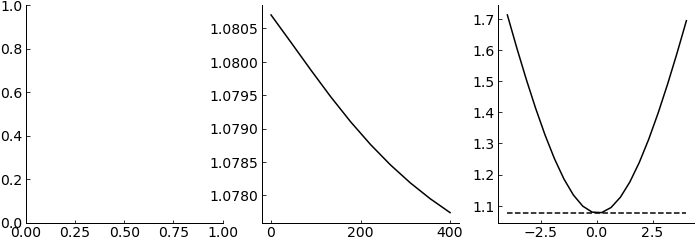

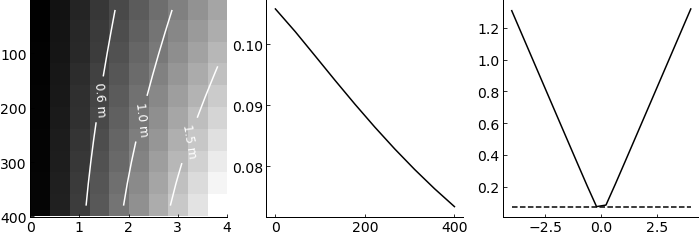

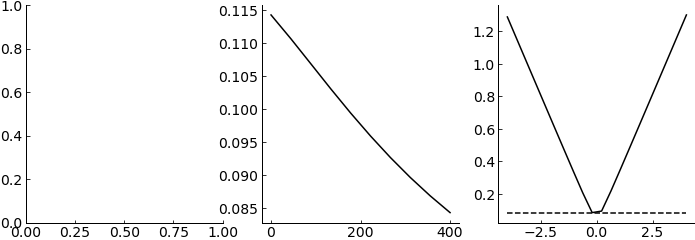

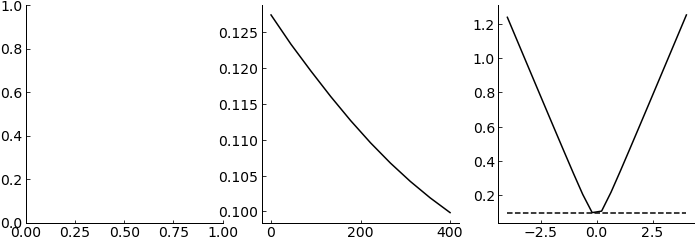

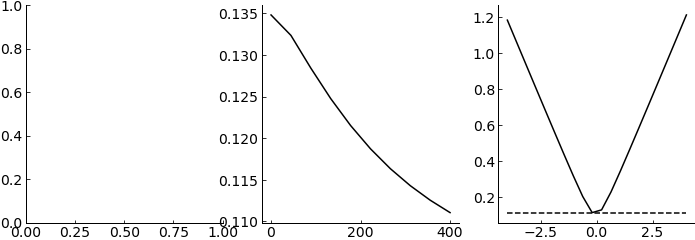

In [70]:
window_sizes = [25, 50, 100, 150, 200]
for dx in window_sizes:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    depths, slips, rmses = plot_rmse_2param_lidar(dx=dx, num=30, max_depth=400, max_slip=4, ax=axes)

Min. RMSE: dx = 25.0 m depth = 0.0 m, dip slip = -0.1 m, strike slip = -4.0 m, RMSE = 0.56 m


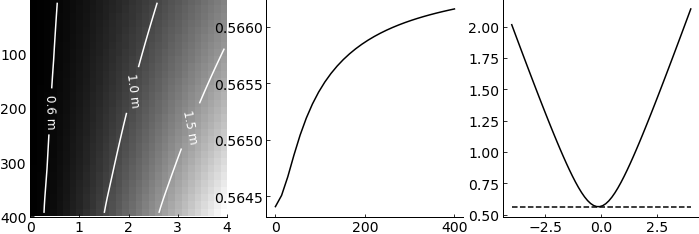

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
depths, slips, rmses = plot_rmse_2param_baseline(dx=50, num=30, max_depth=400, max_slip=4, ax=axes)